# GAN Exercise

In [48]:
#Import and load the 'fashion_mnist' dataset from TensorFlow
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [49]:
#normalizing the pixel values to be between -1 to 1
train_images = train_images / 127.5 - 1
test_images = test_images / 127.5 - 1

In [50]:
ds1_ruben = {
    'images': train_images,
    'labels': train_labels,
}

ds2_ruben = {
    'images': test_images,
    'labels': test_labels,
}

In [51]:
descriptive_labels = [ 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [52]:
dataset_ruben = np.concatenate((ds1_ruben['images'][ds1_ruben['labels']==1], ds2_ruben['images'][ds2_ruben['labels']==1]), axis=0)
dataset_ruben.shape

(7000, 28, 28)

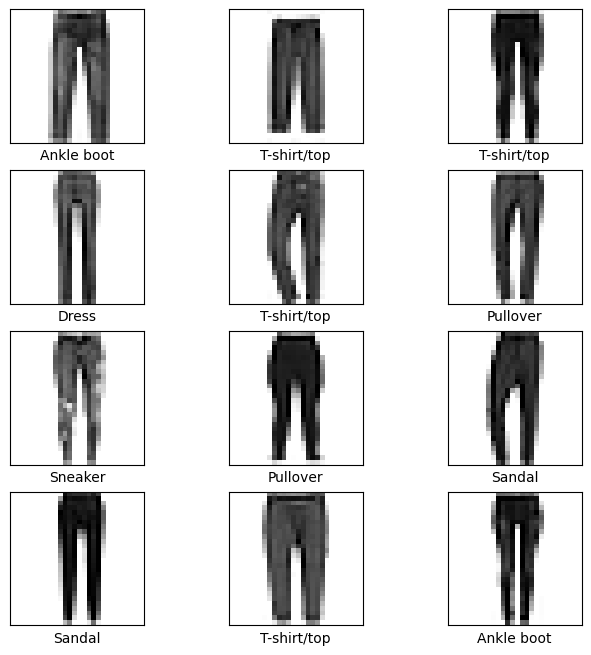

In [53]:
#displaying the first 12 images from the dataset
plt.figure(figsize=(8,8))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dataset_ruben[i], cmap=plt.cm.binary)
    plt.xlabel(descriptive_labels[ds1_ruben['labels'][i]])
plt.show()

In [54]:
train_dataset_ruben = tf.data.Dataset.from_tensor_slices(dataset_ruben)
train_dataset_ruben = train_dataset_ruben.shuffle(buffer_size=7000).batch(256)

## Building the generator model

In [55]:
#Building the generator model of the GAN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose

generator_model_ruben = Sequential()
generator_model_ruben.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
generator_model_ruben.add(Reshape((7, 7, 256)))
generator_model_ruben.add(BatchNormalization())
generator_model_ruben.add(LeakyReLU())
generator_model_ruben.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
generator_model_ruben.add(BatchNormalization())
generator_model_ruben.add(LeakyReLU())
generator_model_ruben.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator_model_ruben.add(BatchNormalization())
generator_model_ruben.add(LeakyReLU())
generator_model_ruben.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

generator_model_ruben.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12544)             1254400   
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 batch_normalization_8 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_9 (Bat  (None, 7, 7, 128)        

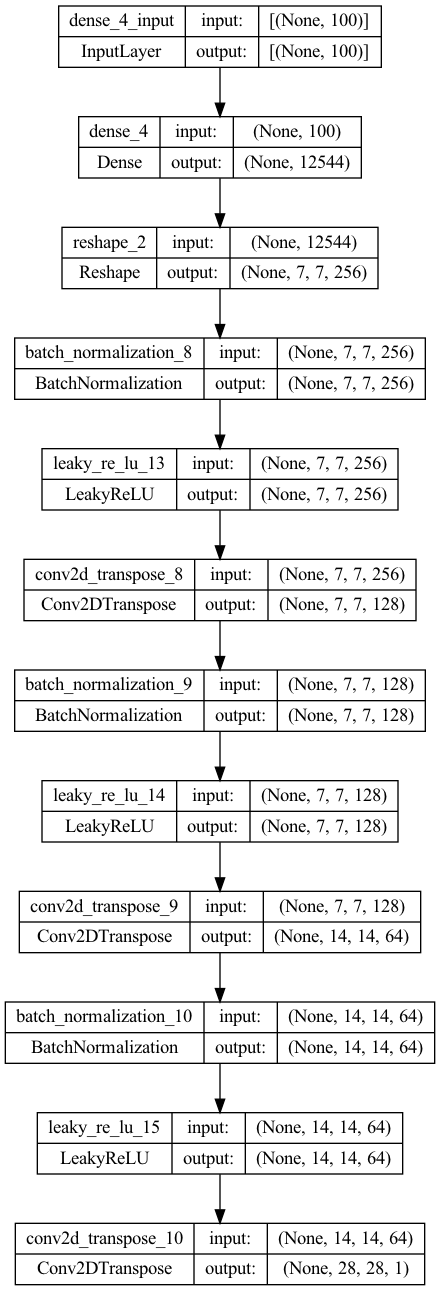

In [56]:
#drawing the generator model
from tensorflow.keras.utils import plot_model
plot_model(generator_model_ruben, show_shapes=True, show_layer_names=True)


## Sampling untrained generator

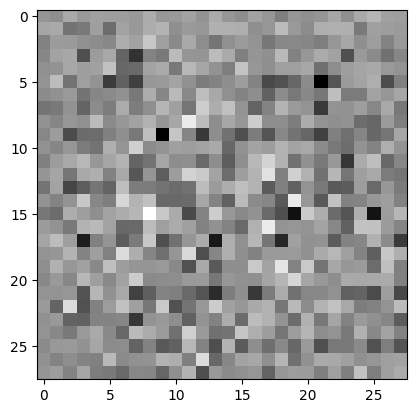

In [57]:
#sample untrained generator
sample_vector = tf.random.normal([1, 100])
sample_image = generator_model_ruben(sample_vector, training=False)
plt.imshow(sample_image[0, :, :, 0], cmap='gray')

In [58]:
#Building the discriminator model of the GAN
from tensorflow.keras.layers import Conv2D, Flatten, Dropout

discriminator_model_ruben = Sequential()
discriminator_model_ruben.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator_model_ruben.add(LeakyReLU())
discriminator_model_ruben.add(Dropout(0.3))
discriminator_model_ruben.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator_model_ruben.add(LeakyReLU())
discriminator_model_ruben.add(Dropout(0.3))
discriminator_model_ruben.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
discriminator_model_ruben.add(BatchNormalization())
discriminator_model_ruben.add(LeakyReLU())
discriminator_model_ruben.add(Flatten())
discriminator_model_ruben.add(Dense(1, activation='sigmoid'))

discriminator_model_ruben.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_11 (Conv2  (None, 14, 14, 64)       

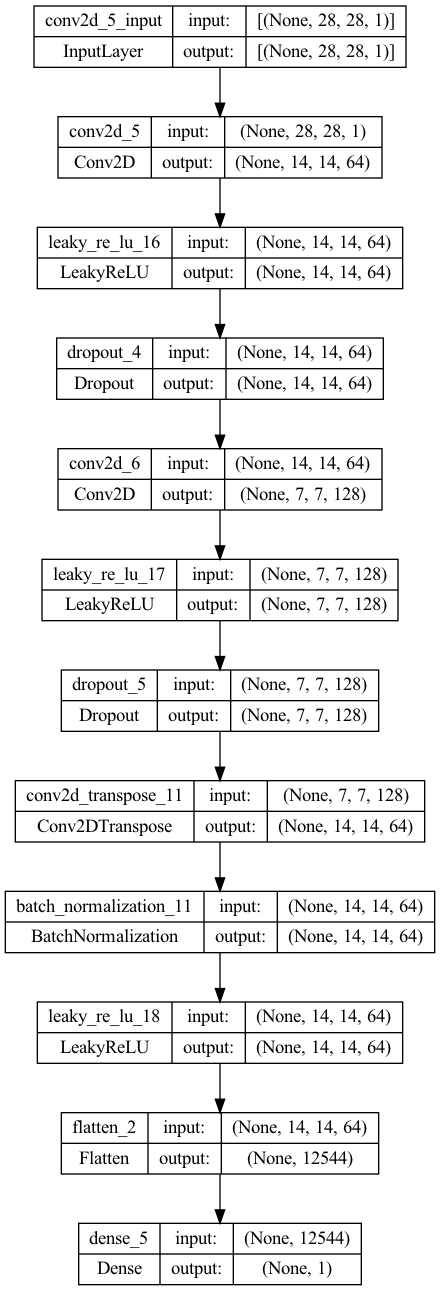

In [59]:
#drawing the discriminator model
plot_model(discriminator_model_ruben, show_shapes=True, show_layer_names=True)


In [60]:
cross_entropy_ruben = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer_ruben = tf.keras.optimizers.Adam()
discriminator_optimizer_ruben = tf.keras.optimizers.Adam()

def training_step(images):
    noise = tf.random.normal([tf.shape(images)[0], 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_model_ruben(noise, training=True)
        real_output = discriminator_model_ruben(images, training=True)
        fake_output = discriminator_model_ruben(generated_images, training=True)
        gen_loss = cross_entropy_ruben(tf.ones_like(fake_output), fake_output)
        real_loss = cross_entropy_ruben(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy_ruben(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model_ruben.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model_ruben.trainable_variables)
    generator_optimizer_ruben.apply_gradients(zip(gradients_of_generator, generator_model_ruben.trainable_variables))
    discriminator_optimizer_ruben.apply_gradients(zip(gradients_of_discriminator, discriminator_model_ruben.trainable_variables))
    return gen_loss, disc_loss

In [61]:
import time

epochs = 10

for epoch in range(epochs):
    start_time = time.time()
    for images in train_dataset_ruben:
        gen_loss, disc_loss = training_step(images)
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start_time))

/Users/ryaol/.local/share/virtualenvs/DeepLearning-rT9ulViY/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 24.21779990196228 sec
Time for epoch 2 is 23.09189510345459 sec
Time for epoch 3 is 23.273464679718018 sec
Time for epoch 4 is 22.81758999824524 sec
Time for epoch 5 is 22.6645610332489 sec
Time for epoch 6 is 22.552928924560547 sec
Time for epoch 7 is 22.502936124801636 sec
Time for epoch 8 is 22.831123113632202 sec
Time for epoch 9 is 22.667046070098877 sec
Time for epoch 10 is 22.792534112930298 sec


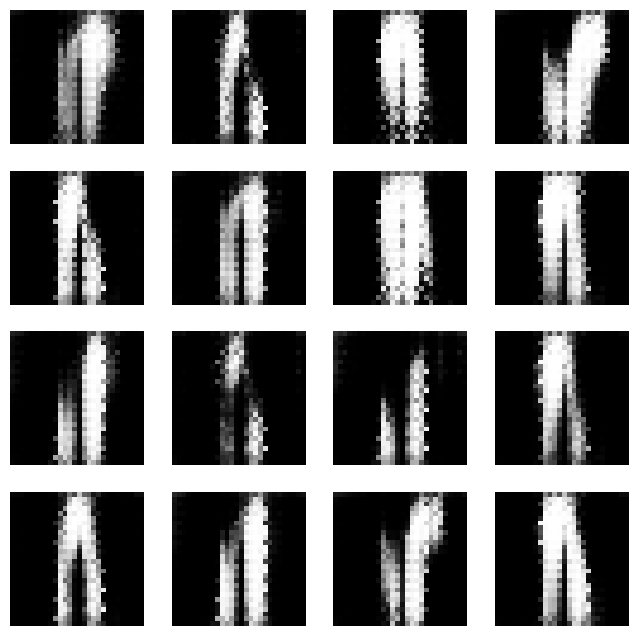

In [62]:
import matplotlib.pyplot as plt

# Generating 16 sample vectors
sample_vectors = tf.random.normal(shape=(16, 100))

# Generating images from the generator
generated_images = generator_model_ruben(sample_vectors, training=False)

# Normalizing the pixels in the generated images
generated_images = (generated_images * 127.5) + 127.5

# Plotting the generated images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()
